In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

In [3]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## PASCAL VOC data setup

In [4]:
# BASE_PATH = '/content/drive/MyDrive/ai/detection/detection-tutorial/'
BASE_PATH = '/content/drive/MyDrive/ai/detection/'

In [5]:
!ls {BASE_PATH}

detection-tutorial     pth	    training_results.ipynb
detectron2_test.ipynb  setup.ipynb  VOCtrainval_11-May-2012.tar


In [6]:
file = BASE_PATH + 'VOCtrainval_11-May-2012.tar'

In [7]:
%%time
!cp {file} .

CPU times: user 484 ms, sys: 109 ms, total: 593 ms
Wall time: 1min 16s


In [8]:
%%time
!tar -xvf ./VOCtrainval_11-May-2012.tar > /dev/null

CPU times: user 276 ms, sys: 61.7 ms, total: 338 ms
Wall time: 49.9 s


In [9]:
!pwd

/content


In [10]:
!ls

drive  sample_data  VOCdevkit  VOCtrainval_11-May-2012.tar


## Imports

In [19]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import os
import numpy as np
import torch
import time
import matplotlib.pyplot as plt

In [21]:
os.chdir("drive/My Drive/ai/detection/detection-tutorial")
# os.chdir("/content/")

FileNotFoundError: ignored

In [ ]:
# import sys
# sys.path.append('./dataset/')
# sys.path.append('./')
# sys.path

In [ ]:
from transforms import get_transform
from utils import format_time, seed_everything
from utils import generate_anchors, find_jaccard_overlap
from utils_plot import show_predictions, show_image_and_bb, show_anchors, show_image_from_dataset

from loss import BoxLoss
from train import run_loader, get_device

from faster_rcnn import faster_rcnn

In [ ]:
# !mkdir ./pascal-voc

In [ ]:
# from dataset.pascal_voc_utils import create_data_lists
# create_data_lists(
#     voc07_path=None,
#     voc12_path='/content/VOCdevkit/VOC2012/',
#     # voc12_path='../VOCdevkit/VOC2012/',
#     output_folder='./pascal-voc/'
# )

In [ ]:
SEED = 2021
seed_everything(SEED)

## PennFudanDataset

In [ ]:
from dataset.penn_fudan_dataset import PennFudanDataset

In [ ]:
# dataset = PennFudanDataset('../PennFudanPed', get_transform(train=False))
dataset = PennFudanDataset('../PennFudanPed', None)

In [ ]:
image, target = dataset[0]

In [ ]:
type(image)

PIL.Image.Image

In [ ]:
target

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1])}

tensor([159., 181., 301., 430.])
tensor([419., 170., 534., 485.])


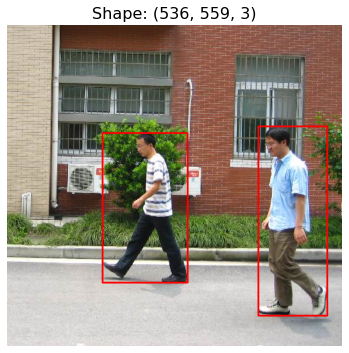

In [ ]:
# show_image(dataset, 0)
show_image_and_bb(image, target)

In [ ]:
anchors = generate_anchors()

In [ ]:
# anchors = anchors[:5]
anchors.shape

torch.Size([441, 4])

In [ ]:
# each anchor we need to match gt_box and binary label - positive
# or 0 label and no box - negative

# We assign a negative label to a non-positive anchor if its IoU ratio is lower than 0.3 for all ground-truth boxes.
# Anchors that are neither positive nor negative do not contribute to the training objective.

# + add delatas for loss

In [ ]:
anchor_labels, gt_offsets = process_anchors(anchors, target['boxes'])

In [ ]:
top_n_anchors, top_n_iou = get_top_n_anchors(anchors, target['boxes'])

In [ ]:
top_n_iou

tensor([0.4745, 0.4732, 0.4732, 0.4691, 0.4008, 0.3733, 0.3733, 0.3644, 0.3631,
        0.3602])

In [ ]:
N = 9
start = 24
# show_anchors(image, target['boxes'], anchors[start*N:(start+1)*N])
# show_anchors(image, target['boxes'], anchors)

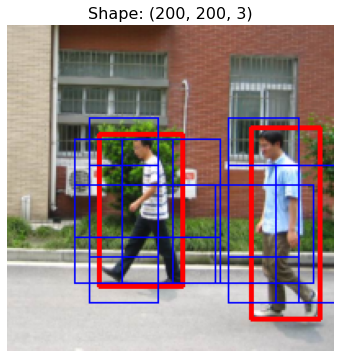

In [ ]:
show_anchors(image, target['boxes'], top_n_anchors)

## PASCAL VOC dataset

In [22]:
from dataset.pascal_voc_dataset import PascalVOCDataset
from utils import generate_anchors

In [23]:
# dataset = PascalVOCDataset('/content/pascal-voc/', 'TRAIN', get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/', 'TRAIN', get_transform(train=True))

In [31]:
generate_anchors_settings = dict(
    clip=True,
    # feature_dims = [50, 25, 13, 7, 4],  
    # feature_map_scales = [
    #     [0.1, 0.3, 0.5],
    #     [0.2, 0.4, 0.6],
    #     [0.3, 0.5, 0.7],
    #     [0.4, 0.6, 0.8],
    #     [0.5, 0.7, 0.9]
    # ],
    feature_dims = [25, 13, 7, 4],
    feature_map_scales = [
        [0.1, 0.3, 0.5],
        [0.2, 0.4, 0.6],
        [0.3, 0.5, 0.8],
        [0.4, 0.6, 0.9]
    ],
    aspect_ratios = [1., 2., 0.5],
)

In [32]:
anchors = generate_anchors(generate_anchors_settings)
anchors.shape

torch.Size([7731, 4])

In [33]:
N = 9
feature_dims = np.array(generate_anchors_settings['feature_dims'])
(feature_dims**2).cumsum()

array([625, 794, 843, 859])

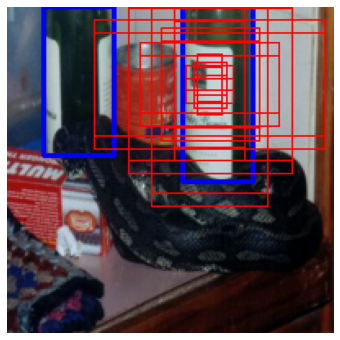

In [36]:
index = 5
image, target = dataset[index]

gt_boxes = target['boxes']

start = 380
anchors_to_show = anchors[start*N:(start+2)*N]
# anchors_to_show = anchors[:500*3]

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, anchors_to_show, verbose=False)

In [ ]:
from torchvision.ops import boxes as box_ops
box_similarity = box_ops.box_iou

In [ ]:
index = 4
image, target = dataset[index]
gt_boxes = target['boxes']

anchors = generate_anchors(clip=True)

In [ ]:
gt_boxes

tensor([[0.4320, 0.4267, 0.5860, 0.5867],
        [0.9280, 0.4427, 0.9980, 0.5787]])

In [ ]:
threshold = 0.5
# jaccard = find_jaccard_overlap(anchors, gt_boxes)
jaccard = box_similarity(anchors, gt_boxes)
print(jaccard.shape)

torch.Size([2577, 2])


In [28]:
def get_positive_anchors(anchors, gt_boxes, threshold=0.3):
    # anchors (N1, 4)
    # gt_boxes (N2, 4)

    jaccard = find_jaccard_overlap(anchors, gt_boxes) # (N1, N2)

    max_iou_for_anchors, gt_boxes_id_for_anchors = jaccard.max(1) # (N1), (N1)

    # fix cases when gt box has no anchor above threshold
    n_objects = gt_boxes.shape[0]
    _, anchor_id_for_object = jaccard.max(0) # (N2), (N2)
    gt_boxes_id_for_anchors[anchor_id_for_object] = torch.LongTensor(range(n_objects))
    max_iou_for_anchors[anchor_id_for_object] = 1

    positive_anchors_mask = (max_iou_for_anchors > threshold) # (N1)
    gt_boxes_id_for_positive_anchors = gt_boxes_id_for_anchors[positive_anchors_mask] # (n_pos_anchors)

    gt_boxes_for_positive_anchors = gt_boxes[gt_boxes_id_for_positive_anchors]  # (n_pos_anchors, 4)
    positive_anchors = anchors[positive_anchors_mask] # (n_pos_anchors, 4)
    positive_iou = max_iou_for_anchors[positive_anchors_mask] # (n_pos_anchors, 1)
    
    return positive_anchors, positive_iou, gt_boxes_for_positive_anchors

Positive anchors number: 3/7731


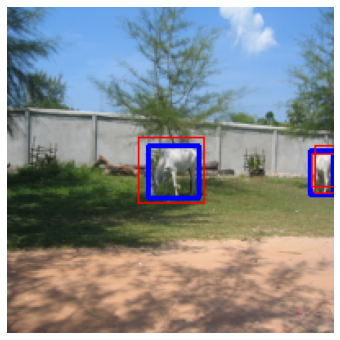

In [37]:
index = 4
image, target = dataset[index]
gt_boxes = target['boxes']

anchors = generate_anchors(generate_anchors_settings)

top_n_anchors, top_n_iou, pos_gt_boxes = get_positive_anchors(anchors, gt_boxes, threshold=0.6)
# top_n_anchors, top_n_iou = get_top_n_anchors(anchors, gt_boxes, top_n=10)

print(f'Positive anchors number: {top_n_anchors.shape[0]}/{anchors.shape[0]}')
# print(top_n_iou)

plt.figure(figsize=(6,6))
# show_image_and_bb(image, target['boxes'])
show_predictions(image, gt_boxes, top_n_anchors, verbose=False)

In [30]:
# index = 5
# show_image_from_dataset(dataset, index, top_n_anchors=10, verbose=True)

## Model single path

In [38]:
def collate_fn(batch):
    # batch: list[tuple]
    # each tuple is (image, target) dictionary
    # turns it into a single tuple (in this case of len == 2)
    
    # TODO: why it's always tuple  
    # print(f'collate_fn, {len(batch)}, {list(zip(*batch))[0]}, {type(list(zip(*batch))[0])}')
    # return list(zip(*batch))
    
    # torch.stack here? for images?
    # do we distinguish targets between images?
    
    return tuple(zip(*batch))

In [39]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

In [40]:
images, targets = next(iter(data_loader))
images = torch.stack(images, dim=0).to(device)
images.shape

torch.Size([8, 3, 200, 200])

In [40]:
# targets

In [41]:
detection_settings = dict(
    clip_predictions=False,
    prob_threshold=0.5,
    max_overlap=0.5
)

net = faster_rcnn(device, generate_anchors_settings, detection_settings).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [42]:
offsets, labels = net(images)
offsets.shape, labels.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(torch.Size([8, 7731, 4]), torch.Size([8, 7731, 1]))

In [43]:
box_loss_settings = dict(
    anchor_threshold = 0.5,
    fix_no_anchors = False,

    enable_random_neg = True,

    enable_hnm = False,
    neg_pos_ratio = 3.0
)

criterion = BoxLoss(device, box_loss_settings, net.anchors)

In [44]:
loss = criterion(labels, offsets, targets)

In [45]:
loss

(tensor(1.4803, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.7854, device='cuda:0', grad_fn=<SmoothL1LossBackward>),
 tensor(0.6949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>))

In [ ]:
-np.log(1/2)

0.6931471805599453

In [ ]:
gt_labels, gt_offsets = criterion.process_target_batch(targets)

In [ ]:
gt_labels.shape, gt_offsets.shape

(torch.Size([8, 2577]), torch.Size([1095, 4]))

In [ ]:
torch.unique(gt_labels, return_counts=True)

(tensor([0, 1], device='cuda:0', dtype=torch.int32),
 tensor([19521,  1095], device='cuda:0'))

In [ ]:
torch.unique(torch.tensor([1,1,0,2]), return_counts=True)

(tensor([0, 1, 2]), tensor([1, 2, 1]))

## Train Model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
len(train_loader)

1443

In [ ]:
params = {
    'learning_rate' : 0.001,
    'weight_decay'  : 0,
    'num_epoch'     : 2
}

model = faster_rcnn()

run_loader(model, train_loader, None, **params)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
[train] index:  0, loss(box/cls) = 2.51103(1.77640/0.73463) time: 0:00:00


/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  boxes = boxes[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  labels = labels[1 - difficulties]
/content/drive/My Drive/ai/detection/detection-tutorial/dataset/pascal_voc_dataset.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  difficulties = difficulties[1 - difficulties]


[train] index: 100, loss(box/cls) = 2.08980(1.67377/0.41603) time: 0:00:07
[train] index: 200, loss(box/cls) = 1.53724(1.12103/0.41621) time: 0:00:14
[train] index: 300, loss(box/cls) = 1.54284(1.17414/0.36871) time: 0:00:20
[train] index: 400, loss(box/cls) = 1.33409(0.94387/0.39022) time: 0:00:27
[train] index: 500, loss(box/cls) = 1.23265(0.95894/0.27371) time: 0:00:34
[train] index: 600, loss(box/cls) = 1.47188(1.15760/0.31429) time: 0:00:41
[train] index: 700, loss(box/cls) = 1.38084(1.11081/0.27003) time: 0:00:48
[train] index: 800, loss(box/cls) = 1.13748(0.78485/0.35264) time: 0:00:54
[train] index: 900, loss(box/cls) = 1.44728(1.20427/0.24301) time: 0:01:01
[train] index: 1000, loss(box/cls) = 1.23932(0.86597/0.37335) time: 0:01:08
[train] index: 1100, loss(box/cls) = 0.96726(0.75159/0.21567) time: 0:01:14
[train] index: 1200, loss(box/cls) = 1.32545(1.02724/0.29821) time: 0:01:21
[train] index: 1300, loss(box/cls) = 1.23931(0.93166/0.30765) time: 0:01:28
[train] index: 1400, 

{}

## Run

In [49]:
from train import main, run

from utils_plot import show_loss_history, show_loss_epochs_all, show_scores
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [49]:
# train_info = main(debug=True)

In [79]:
generate_anchors_settings = dict(
    clip=True,
    feature_dims = [50, 25, 13, 7, 4],
    feature_map_scales = [
        [0.1, 0.3, 0.5],
        [0.2, 0.4, 0.6],
        [0.3, 0.5, 0.7],
        [0.4, 0.6, 0.8],
        [0.5, 0.7, 0.9]
    ],
    aspect_ratios = [1., 2., 0.5],
)

box_loss_settings = dict(
    anchor_threshold = 0.6,
    fix_no_anchors = True,

    enable_random_neg = True,
    enable_hnm = False,
    neg_pos_ratio = 3.0
)

detection_settings = dict(
    clip_predictions=True,
    prob_threshold=0.8,
    max_overlap=0.3
)

params = {
    'generate_anchors_settings' : generate_anchors_settings,
    'box_loss_settings' : box_loss_settings,
    'detection_settings' : detection_settings,

    # 'rpn_heads' : 0,

    'learning_rate'     : 0.001,
    'weight_decay'      : 0,
    'batch_size'        : 8,
    'num_epoch'         : 10,
    'verbose'           : True,
    'print_params'      : False, # False in notebook
    'debug'             : False
}
seed_everything(SEED)
train_info, valid_loader, model = run(**params)

data size, all: 11540, train: 10386
data loader size, train: 1299, valid: 145
batch_size = 8
There are 1 GPU(s) available.
We will use the GPU: Tesla T4
training started...
[train] epoch:  1, loss(box/cls) = 0.83865(0.41392/0.42474), time: 0:02:38
save
[valid] epoch:  1, loss(box/cls) = 0.78994(0.39862/0.39132), mAP = 0.00000,  time: 0:02:50
[train] epoch:  2, loss(box/cls) = 0.75392(0.38360/0.37031), time: 0:02:40
save
[valid] epoch:  2, loss(box/cls) = 0.74894(0.39080/0.35814), mAP = 0.00000,  time: 0:02:53
[train] epoch:  3, loss(box/cls) = 0.70965(0.36931/0.34033), time: 0:02:40
save
[valid] epoch:  3, loss(box/cls) = 0.73096(0.37766/0.35330), mAP = 0.00000,  time: 0:02:52
[train] epoch:  4, loss(box/cls) = 0.67137(0.35766/0.31371), time: 0:02:41
save
[valid] epoch:  4, loss(box/cls) = 0.70145(0.37206/0.32939), mAP = 0.00000,  time: 0:02:53
[train] epoch:  5, loss(box/cls) = 0.63415(0.34411/0.29004), time: 0:02:40
save
[valid] epoch:  5, loss(box/cls) = 0.68690(0.36192/0.32498), mA

In [52]:
generate_anchors_settings = dict(
    clip=False,
    feature_dims = [25, 13, 7, 4], # TODO: Read from image?
    # scales = [0.9, 0.6, 0.3],
    feature_map_scales = [
        [0.1, 0.3, 0.5],
        [0.2, 0.4, 0.6],
        [0.3, 0.5, 0.8],
        [0.4, 0.6, 0.9]
    ],
    aspect_ratios = [1., 2., 0.5],
)

box_loss_settings = dict(
    anchor_threshold = 0.5,
    fix_no_anchors = False,

    enable_random_neg = True,
    enable_hnm = False,  
    neg_pos_ratio = 3.0
)

# detection_settings = dict(
#     clip_predictions=False,
#     prob_threshold=0.5,
#     max_overlap=0.7
# )

detection_settings = dict(
    clip_predictions=True,
    prob_threshold=0.7,
    max_overlap=0.3
)

params = {
    'generate_anchors_settings' : generate_anchors_settings,
    'box_loss_settings' : box_loss_settings,
    'detection_settings' : detection_settings,

    # 'rpn_heads' : 0,

    'learning_rate'     : 0.001,
    'weight_decay'      : 0,
    'batch_size'        : 8,
    'num_epoch'         : 15,
    'verbose'           : True,
    'print_params'      : False, # False in notebook
    'debug'             : False
}
seed_everything(SEED)
train_info, valid_loader, model = run(**params)

data size, all: 11540, train: 10386
data loader size, train: 1299, valid: 145
batch_size = 8
There are 1 GPU(s) available.
We will use the GPU: Tesla K80
training started...
[train] epoch:  1, loss(box/cls) = 0.92619(0.54159/0.38460), time: 0:03:56
[mAP__] n_objects/n_detections: 3337/6073
save
[valid] epoch:  1, loss(box/cls) = 0.84507(0.49893/0.34614), mAP = 0.23520,  time: 0:04:56
[train] epoch:  2, loss(box/cls) = 0.77535(0.46673/0.30862), time: 0:03:57
[mAP__] n_objects/n_detections: 3337/6208
save
[valid] epoch:  2, loss(box/cls) = 0.78201(0.47441/0.30760), mAP = 0.25257,  time: 0:04:57


KeyboardInterrupt: ignored

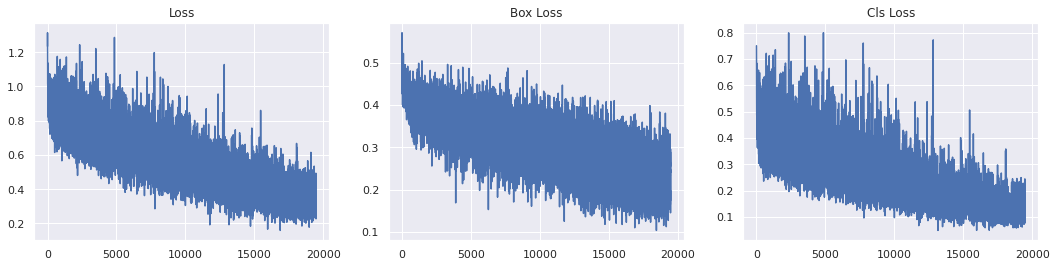

In [62]:
show_loss_history(train_info)

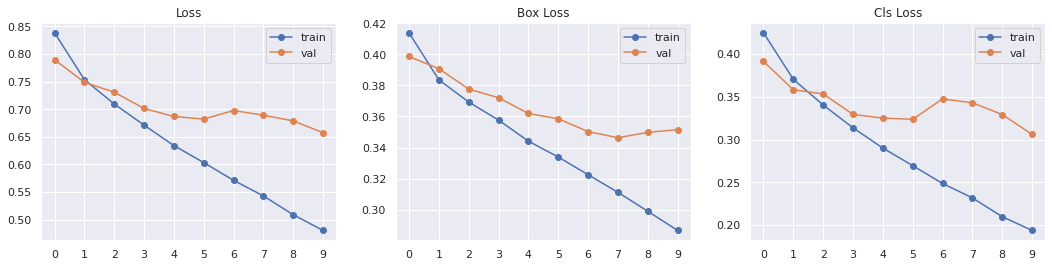

In [80]:
show_loss_epochs_all(train_info)

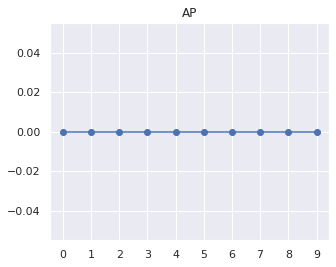

In [81]:
show_scores(train_info)

In [ ]:
# train_info['train_cls_loss_history']

In [93]:
epochs = 120000 // (len(dataset) // 32)
epochs

333

In [77]:
model_path = os.path.join(BASE_PATH, 'pth/faster_rcnn_model_50_15_2.pth')
torch.save(model.state_dict(), model_path)

## Show predictions

In [94]:
from utils_plot import show_predictions

In [95]:
device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [96]:
len(valid_loader)

145

In [97]:
images, targets = next(iter(valid_loader))

In [98]:
images = torch.stack(images, dim=0).to(device)

In [ ]:
# model = faster_rcnn(device)
# model = net

# model_path = '../pth/faster_rcnn_model_0.pth'
# model.load_state_dict(torch.load(model_path, map_location='cpu'))

# model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_0.pth')
# model.load_state_dict(torch.load(model_path))

In [99]:
model.eval()
print('')

In [100]:
offsets, labels = model(images)

In [67]:
# detection_settings
detection_settings = dict(
    clip_predictions=False,
    prob_threshold=0.7,
    max_overlap=0.3
)

model.clip_predictions = detection_settings['clip_predictions']
model.prob_threshold = detection_settings['prob_threshold']
model.max_overlap = detection_settings['max_overlap']

In [101]:
pred_boxes, pred_conf = model.detect(offsets, labels)

GT:
tensor([ 70.2857,  94.4000, 173.7143, 170.0000])
tensor([121.7143, 112.8000, 137.1429, 134.0000])
Predictions:
tensor([ 73.9914,  91.4508, 170.6254, 167.9013], grad_fn=<UnbindBackward>)
Shape: (200, 200, 3)


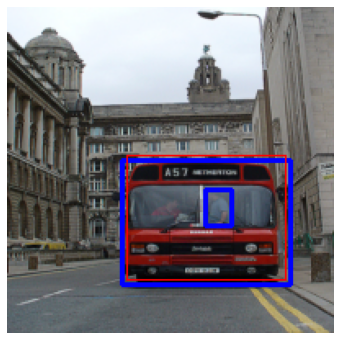

In [110]:
plt.figure(figsize=(6,6))
image_index = 7
gt_boxes = targets[image_index]['boxes']
final_boxes = pred_boxes[image_index].cpu()
show_predictions(images[image_index], gt_boxes, final_boxes, verbose=True)

## Evaluation

In [ ]:
from utils import calculate_mAP

In [75]:
# det_boxes = pred_boxes
# det_scores = pred_conf
# true_boxes = [t['boxes'] for t in targets]
# true_labels = [t['labels'] for t in targets]

In [ ]:
calculate_mAP(pred_boxes, pred_conf, true_boxes, true_labels, device)

tensor(0.3829, device='cuda:0')

In [31]:
from train import validate

In [49]:
generate_anchors_settings = dict(
    clip=False,
    feature_dims = [50, 25, 13, 7, 4],
    feature_map_scales = [
        [0.1, 0.3, 0.5],
        [0.2, 0.4, 0.6],
        [0.3, 0.5, 0.7],
        [0.4, 0.6, 0.8],
        [0.5, 0.7, 0.9]
    ],
    aspect_ratios = [1., 2., 0.5],
)

box_loss_settings = dict(
    anchor_threshold = 0.6,
    fix_no_anchors = False,

    enable_random_neg = True,
    enable_hnm = False,
    neg_pos_ratio = 3.0
)

detection_settings = dict(
    clip_predictions=True,
    prob_threshold=0.8,
    max_overlap=0.3
)

model = faster_rcnn(device, generate_anchors_settings, detection_settings).to(device)
model_path = os.path.join(BASE_PATH, 'faster_rcnn_model_50.pth')
model.load_state_dict(torch.load(model_path))

criterion = BoxLoss(device, box_loss_settings, model.anchors)

In [83]:
detection_settings = dict(
    clip_predictions=True,
    prob_threshold=0.8,
    max_overlap=0.3
)

model.clip_predictions = detection_settings['clip_predictions']
model.prob_threshold = detection_settings['prob_threshold']
model.max_overlap = detection_settings['max_overlap']

loss_meters, mAP = validate(model, device, criterion, valid_loader)

[valid] index:  0, loss(box/cls) = 0.54732(0.22783/0.31949) time: 0:00:01
[valid] index: 50, loss(box/cls) = 0.60309(0.20937/0.39372) time: 0:00:45
[valid] index: 100, loss(box/cls) = 0.60586(0.21276/0.39310) time: 0:01:29
[valid] calculate_mAP... time: 0:02:05
[mAP__] n_objects/n_detections: 3337/9764
[valid] mAP = 0.29855,  time: 0:02:11


### New dataset

In [173]:
sampler = torch.utils.data.SubsetRandomSampler(range(500))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,
    sampler=sampler,
    num_workers=0,
    collate_fn=collate_fn
)

In [184]:
generate_anchors_settings = dict(
    clip=True,
    feature_dims = [50, 25, 13, 7, 4],
    feature_map_scales = [
        [0.1, 0.3, 0.5],
        [0.2, 0.4, 0.6],
        [0.3, 0.5, 0.7],
        [0.4, 0.6, 0.8],
        [0.5, 0.7, 0.9]
    ],
    aspect_ratios = [1., 2., 0.5],
)

# generate_anchors_settings = dict(
#     clip=False,
#     feature_dims = [25, 13, 7, 4], # TODO: Read from image?
#     # scales = [0.9, 0.6, 0.3],
#     feature_map_scales = [
#         [0.1, 0.3, 0.5],
#         [0.2, 0.4, 0.6],
#         [0.3, 0.5, 0.8],
#         [0.4, 0.6, 0.9]
#     ],
#     aspect_ratios = [1., 2., 0.5],
# )

detection_settings = dict(
    clip_predictions=False,
    prob_threshold=0.8,
    max_overlap=0.3
)

net = faster_rcnn(device, generate_anchors_settings, detection_settings).to(device)

In [185]:
box_loss_settings = dict(
    anchor_threshold = 0.5,
    fix_no_anchors = False,

    enable_random_neg = True,

    enable_hnm = False,
    neg_pos_ratio = 3.0
)

criterion = BoxLoss(device, box_loss_settings, net.anchors)

In [186]:
loss_meters, mAP = validate(net, device, criterion, data_loader)

[valid] index:  0, loss(box/cls) = 1.42974(0.76781/0.66194) time: 0:00:00
[valid] index: 50, loss(box/cls) = 1.44648(0.78867/0.65781) time: 0:00:05
[valid] calculate_mAP... time: 0:00:07
[mAP__] n_objects/n_detections: 1180/127
[valid] mAP = 0.00884,  time: 0:00:07


In [177]:
loss_meters, mAP = validate(net, device, criterion, data_loader)

[valid] index:  0, loss(box/cls) = 1.44706(0.70964/0.73742) time: 0:00:00
[valid] index: 50, loss(box/cls) = 1.45028(0.74574/0.70454) time: 0:00:06
[valid] calculate_mAP... time: 0:00:07
[mAP__] n_objects/n_detections: 1180/10097
[valid] mAP = 0.00084,  time: 0:00:13


In [ ]:
loss_meters, mAP = validate(net, device, criterion, data_loader)

[valid] index:  0, loss(box/cls) = 1.53439(0.79355/0.74083) time: 0:00:02
[valid] index:  2, loss(box/cls) = 1.47362(0.75247/0.72116) time: 0:00:07
[valid] index:  4, loss(box/cls) = 1.49176(0.76796/0.72380) time: 0:00:11
[valid] index:  6, loss(box/cls) = 1.49908(0.77509/0.72398) time: 0:00:15
[valid] index:  8, loss(box/cls) = 1.48888(0.76435/0.72453) time: 0:00:19
[valid] calculate_mAP... time: 0:00:21
torch.Size([110, 4])
torch.Size([106154, 4])
[valid] mAP = 0.00325,  time: 0:00:36


In [ ]:
loss_meters, mAP = validate(net, device, criterion, data_loader)

[valid] index:  0, loss(box/cls) = 1.53726(0.76533/0.77192) time: 0:00:01
[valid] index:  2, loss(box/cls) = 1.53527(0.76565/0.76962) time: 0:00:03
[valid] index:  4, loss(box/cls) = 1.52073(0.75619/0.76454) time: 0:00:05
[valid] index:  6, loss(box/cls) = 1.51679(0.76017/0.75662) time: 0:00:07
[valid] index:  8, loss(box/cls) = 1.51153(0.76098/0.75054) time: 0:00:09
[valid] calculate_mAP... time: 0:00:10
torch.Size([110, 4])
torch.Size([53893, 4])
[valid] mAP = 0.00356,  time: 0:00:18


In [ ]:
mAP

tensor(0.2871, device='cuda:0')

## ipywidgets

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

In [ ]:
# dataset = PascalVOCDataset('./pascal-voc/', transforms=get_transform(train=True))
dataset = PascalVOCDataset('./pascal-voc/')

get_transform_to_show


In [ ]:
w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=len(dataset),
    step=1,
    description='Image:',
    disabled=False
)

def handle_change(x):
    print(x)
    show_image_from_dataset(dataset, x, top_n_anchors=0)

In [ ]:
# do it only once

# import json
# # with open('./pascal-voc/label_map.json'), 'r') as j:
# data_folder = './pascal-voc'
# with open(os.path.join(data_folder, 'label_map.json'), 'r') as j:
#     labels = json.load(j)

In [ ]:
interact(handle_change, x=w)

interactive(children=(BoundedIntText(value=0, description='Image:', max=11540), Output()), _dom_classes=('widg…

<function __main__.handle_change(x)>

## Trainimg